<a href="https://colab.research.google.com/github/geraldalivia/Satellite-Image-Classification/blob/main/Image_Classification_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Satellite Image Classification
- **Nama:** Geralda Livia Nugraha
- **Email:** geraldaliviaa93@gmail.com || mc299d5x1168@student.devacademy.id
- **ID Dicoding:** alddar (MC299D5X1168)

Archieve : https://drive.google.com/drive/folders/1T4GI5UtHUBpL9ogif97WmlBHLoJr7mRw?usp=sharing

## Import Semua Packages/Library yang Digunakan

In [4]:
# Intall Depedencies
!pip install tensorflowjs
!pip freeze > requirements.txt

In [26]:
# Library
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from pathlib import Path

# Load Data dan Akses ke Drive
from google.colab import drive

# Processing Data
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

# Build Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Save Model
import tensorflow as tf
import tensorflowjs as tfjs

# Inference
from PIL import Image

In [15]:
# Untuk requirement.txt
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data Preparation

### Data Loading

In [3]:
# Mounting GDrive
drive.mount('/content/drive')

# Load dataset .zip
!unzip "/content/drive/MyDrive/Submission/Deep Learning/Image Classification/Dataset/Satellite.zip" -d "/content/satellite_dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/satellite_dataset/data/cloudy/train_23566.jpg  
  inflating: /content/satellite_dataset/data/cloudy/train_23598.jpg  
  inflating: /content/satellite_dataset/data/cloudy/train_23608.jpg  
  inflating: /content/satellite_dataset/data/cloudy/train_23634.jpg  
  inflating: /content/satellite_dataset/data/cloudy/train_23636.jpg  
  inflating: /content/satellite_dataset/data/cloudy/train_23646.jpg  
  inflating: /content/satellite_dataset/data/cloudy/train_2366.jpg  
  inflating: /content/satellite_dataset/data/cloudy/train_23664.jpg  
  inflating: /content/satellite_dataset/data/cloudy/train_23706.jpg  
  inflating: /content/satellite_dataset/data/cloudy/train_2380.jpg  
  inflating: /content/satellite_dataset/data/cloudy/train_23805.jpg  
  inflating: /content/satellite_dataset/data/cloudy/train_23806.jpg  
  inflating: /content/satellite_dataset/data/cloudy/train_23826.jpg  
  inflating: /content/satellite_dataset/d

### Data Exploratory

In [6]:
# Mengenali Dataset
path = "/content/satellite_dataset/data"

classes = sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])
print("Classes:", classes)

class_counts = {}
for cls in classes:
    cls_path = os.path.join(path, cls)
    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[cls] = len(images)

data = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
print(data)

Classes: ['cloudy', 'desert', 'green_area', 'water']
        Class  Count
0      cloudy   1500
1      desert   1131
2  green_area   1500
3       water   1500


<ipython-input-7-1318366b304a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=data, palette='pastel')


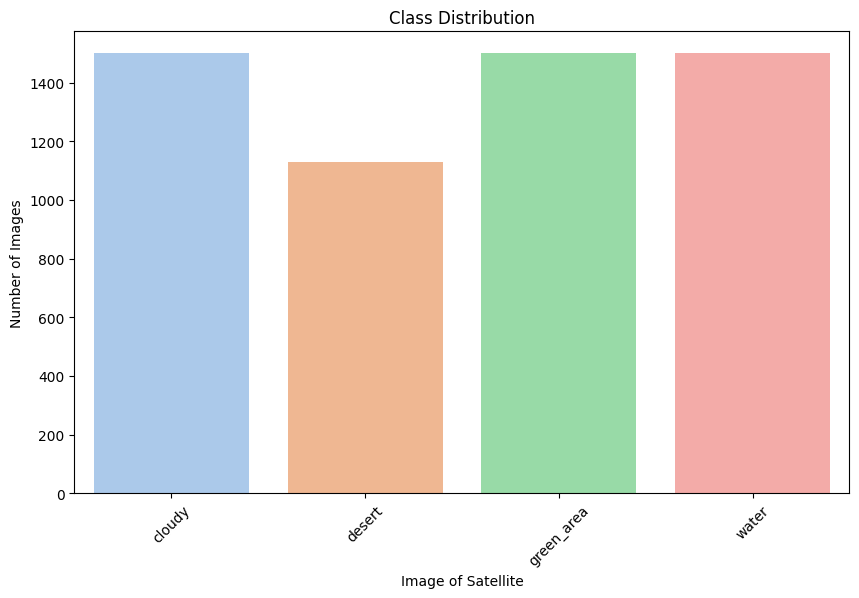

In [7]:
# Menampilkan Plot tiap Class
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', data=data, palette='pastel')
plt.title('Class Distribution')
plt.xlabel('Image of Satellite')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

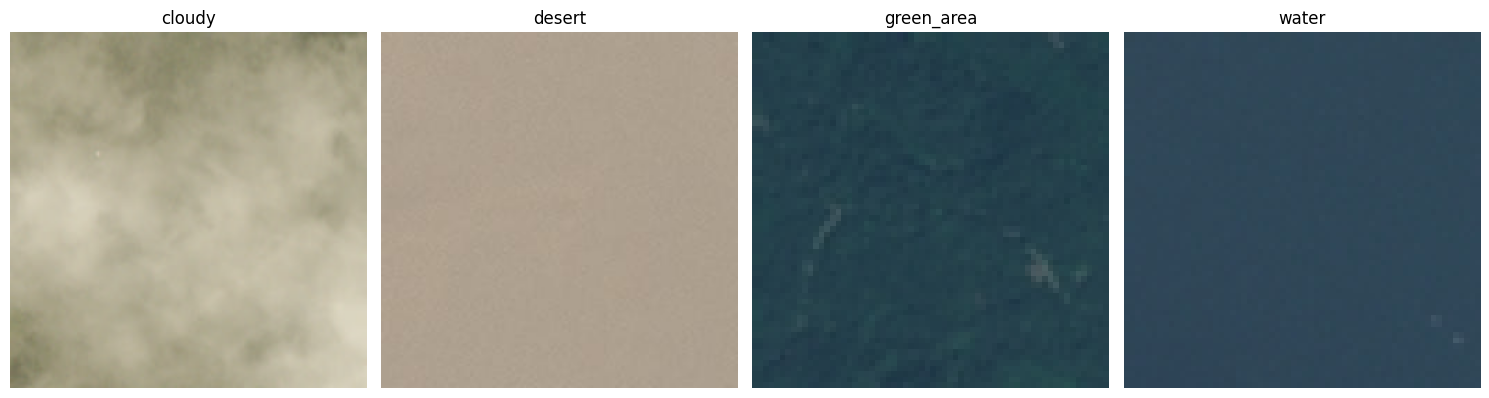

In [8]:
# Menampilkan visualisasi beberapa gambar dari tiap kelas
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 10))
axes = axes.flatten()

for i, cls in enumerate(classes):
    if i >= 12:
        break
    img_path = os.path.join(path, cls, os.listdir(os.path.join(path, cls))[0])
    img = plt.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Data Preprocessing

#### Split Dataset

In [9]:
# Path dataset yang digunakan
path = "/content/satellite_dataset/data"
new_path = "/content/satellite_dataset_split" # buat output

# Rasio pembagian data
train_ratio = 0.7  # 70% training
val_ratio = 0.15   # 15% validation
test_ratio = 0.15  # 15% testing

# Daftar kelas
classes = ['cloudy', 'desert', 'green_area', 'water']

# Membuat folder untuk output berdasarkan train, val, test
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(f"{new_path}/{split}/{cls}", exist_ok=True)

In [10]:
# Proses mengisi folder tiap kelas
for cls in classes:
    # ambil data dari base path
    cls_path = os.path.join(path, cls)
    images = [f for f in os.listdir(cls_path)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # mengambil gamabr random
    random.shuffle(images)

    # Menghitung jumlah setiap split
    total_images = len(images)
    train_count = int(total_images * train_ratio)
    val_count = int(total_images * val_ratio)
    test_count = total_images - train_count - val_count

    print(f"\nKelas {cls}: {total_images} gambar")
    print(f"  - Train: {train_count} gambar")
    print(f"  - Validation: {val_count} gambar")
    print(f"  - Test: {test_count} gambar")

    # Split data untuk train, val, test
    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Copy files random tadi ke folder yang sesuai
    for img in train_images:
        src = os.path.join(cls_path, img)
        dst = os.path.join(new_path, 'train', cls, img)
        shutil.copy2(src, dst)

    for img in val_images:
        src = os.path.join(cls_path, img)
        dst = os.path.join(new_path, 'val', cls, img)
        shutil.copy2(src, dst)

    for img in test_images:
        src = os.path.join(cls_path, img)
        dst = os.path.join(new_path, 'test', cls, img)
        shutil.copy2(src, dst)


Kelas cloudy: 1500 gambar
  - Train: 1050 gambar
  - Validation: 225 gambar
  - Test: 225 gambar

Kelas desert: 1131 gambar
  - Train: 791 gambar
  - Validation: 169 gambar
  - Test: 171 gambar

Kelas green_area: 1500 gambar
  - Train: 1050 gambar
  - Validation: 225 gambar
  - Test: 225 gambar

Kelas water: 1500 gambar
  - Train: 1050 gambar
  - Validation: 225 gambar
  - Test: 225 gambar


In [11]:
# Verifikasi hasil copy data untuk split
for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()}:")
    total_split = 0
    for cls in classes:
        count = len(os.listdir(f"{new_path}/{split}/{cls}"))
        print(f"  {cls}: {count} gambar")
        total_split += count
    print(f"  Total {split}: {total_split} gambar")


TRAIN:
  cloudy: 1050 gambar
  desert: 791 gambar
  green_area: 1050 gambar
  water: 1050 gambar
  Total train: 3941 gambar

VAL:
  cloudy: 225 gambar
  desert: 169 gambar
  green_area: 225 gambar
  water: 225 gambar
  Total val: 844 gambar

TEST:
  cloudy: 225 gambar
  desert: 171 gambar
  green_area: 225 gambar
  water: 225 gambar
  Total test: 846 gambar


In [12]:
###
## Copy data Split dari Colab ke Drive
###
colab_data = '/content/satellite_dataset_split'

if os.path.exists(colab_data):
    # Cek isi data
    print("Isi data split:")
    for item in os.listdir(colab_data):
        item_path = os.path.join(colab_data, item)
        if os.path.isdir(item_path):
            count = len(os.listdir(item_path))
            print(f" file {item}/ - {count} subfolder")

    # Target lokasi untuk dipindah
    drive_path = '/content/drive/MyDrive/satellite_dataset_split'
    print(f"\nMemindahkan data ke Drive")

    # Copy data dari Colab ke Drive
    if not os.path.exists(drive_path):
        shutil.copytree(colab_data, drive_path)
        print("Data berhasil dipindah ke Google Drive!")
    else:
        print("Data sudah ada di Google Drive")

    # Verifikasi data sudah ada di Drive
    print(f"\n Lokasi data di Drive: {drive_path}")

    for item in os.listdir(drive_path):
        item_path = os.path.join(drive_path, item)
        if os.path.isdir(item_path):
            # Hitung jumlah gambar di setiap folder
            total_images = 0
            subfolders = os.listdir(item_path)
            print(f"  📁 {item}/")

            for subfolder in subfolders:
                subfolder_path = os.path.join(item_path, subfolder)
                if os.path.isdir(subfolder_path):
                    count = len([f for f in os.listdir(subfolder_path)
                               if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                    total_images += count
                    print(f"    📂 {subfolder}: {count} gambar")

            print(f"Total {item}: {total_images} gambar")

    print(f"Data sekarang tersimpan di Google Drive Anda")

else:
    print("Data split tidak ditemukan ")

Isi data split:
 file val/ - 4 subfolder
 file train/ - 4 subfolder
 file test/ - 4 subfolder

Memindahkan data ke Drive
Data berhasil dipindah ke Google Drive!

 Lokasi data di Drive: /content/drive/MyDrive/satellite_dataset_split
  📁 val/
    📂 green_area: 225 gambar
    📂 water: 225 gambar
    📂 desert: 169 gambar
    📂 cloudy: 225 gambar
Total val: 844 gambar
  📁 train/
    📂 green_area: 1050 gambar
    📂 water: 1050 gambar
    📂 desert: 791 gambar
    📂 cloudy: 1050 gambar
Total train: 3941 gambar
  📁 test/
    📂 green_area: 225 gambar
    📂 water: 225 gambar
    📂 desert: 171 gambar
    📂 cloudy: 225 gambar
Total test: 846 gambar
Data sekarang tersimpan di Google Drive Anda


## Modelling
Membangun model CNN

In [13]:
###
## Setup Base Data Yang Digunakan
###

# Base Data menggunakan satellite_dataset_split
data_path = "/content/satellite_dataset_split"

# Setting random
tf.random.set_seed(42)

# Parameter gambar
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4  # cloudy, desert, green_area, water

# Data generator untuk train
train_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Data Generator untuk validation dan test
val_test_data = ImageDataGenerator(rescale=1./255)


###
## Load Data Training, Testing, Validation
###

# Load data training
train_generator = train_data.flow_from_directory(
    f"{data_path}/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Load data validation
val_generator = val_test_data.flow_from_directory(
    f"{data_path}/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load data test
test_generator = val_test_data.flow_from_directory(
    f"{data_path}/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Kelas yang ditemukan:", train_generator.class_indices)

Found 3941 images belonging to 4 classes.
Found 844 images belonging to 4 classes.
Found 846 images belonging to 4 classes.
Kelas yang ditemukan: {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


In [14]:
###
## Build Model CNN
###

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),  # Conv1
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),     # Conv2
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),    # Conv3
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),    # Conv4
    MaxPooling2D(2, 2),

    Flatten(),  # Mengubah dari 2D ke 1D, diratain gitu (flat)

    # Fully Connected Layers
    Dense(512, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(256, activation='relu'),
    Dropout(0.3),

    Dense(NUM_CLASSES, activation='softmax')  # Output layer
])


###
## Compile dan Menampilkan Model CNN
###
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,395,652 (73.99 MB)

 Trainable params: 19,395,652 (73.99 MB)

 Non-trainable params: 0 (0.00 B)

## Training Model

In [16]:
# Stop training jika model ditrain tidak improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Mengurangi learning rate jika stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001
)

callbacks = [early_stopping, reduce_lr]

In [ ]:
EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 66s 449ms/step - accuracy: 0.5762 - loss: 0.7990 - val_accuracy: 0.6078 - val_loss: 0.6473 - learning_rate: 0.0010
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 49s 394ms/step - accuracy: 0.6789 - loss: 0.5830 - val_accuracy: 0.7334 - val_loss: 0.4755 - learning_rate: 0.0010
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 83s 403ms/step - accuracy: 0.7067 - loss: 0.5646 - val_accuracy: 0.8318 - val_loss: 0.3927 - learning_rate: 0.0010
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 50s 402ms/step - accuracy: 0.8220 - loss: 0.4225 - val_accuracy: 0.7358 - val_loss: 0.4968 - learning_rate: 0.0010
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 49s 392ms/step - accuracy: 0.8323 - loss: 0.3852 - val_accuracy: 0.8602 - val_loss: 0.3416 - learning_rate: 0.0010
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 50s 401ms/step - accuracy: 0.8192 - loss: 0.4219 - val_accuracy: 0.8412 - val_loss: 0.3164 - learning_rate: 0.0010
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 50s 400ms/step - accuracy: 0.8

## Evaluasi dan Visualisasi

In [ ]:
# Menampilkan hasil akurasi model cnn
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Test Loss: 0.1575
Test Accuracy: 0.9374 (93.74%)


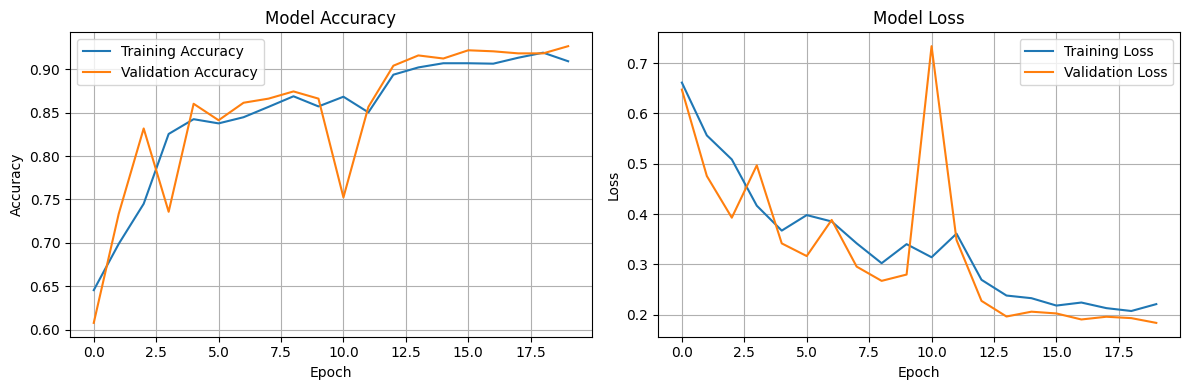

In [ ]:
# Menampilkan plot grafik training
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Konversi Model

In [20]:
###
## SavedModel (.pb)
##

# Path untuk menyimpan SavedModel
savedmodel_dir = "/content/drive/MyDrive/saved_model"

# Menghapus folder lama jika ada
if os.path.exists(savedmodel_dir):
    shutil.rmtree(savedmodel_dir)

# Menyimpan model dalam format SavedModel
tf.saved_model.save(model, savedmodel_dir)

# Melakukan verifikasi struktur file SavedModel
print(f"\nStruktur file SavedModel di: {savedmodel_dir}")
for root, dirs, files in os.walk(savedmodel_dir):
    level = root.replace(savedmodel_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        file_size = os.path.getsize(os.path.join(root, file)) / (1024*1024)
        print(f"{subindent}{file} ({file_size:.2f} MB)")

# Mengetahui ukuran file savedmodel
total_size = sum(os.path.getsize(os.path.join(dirpath, filename))
                for dirpath, dirnames, filenames in os.walk(savedmodel_dir)
                for filename in filenames) / (1024*1024)
print(f"\nTotal ukuran SavedModel: {total_size:.2f} MB")


Struktur file SavedModel di: /content/drive/MyDrive/saved_model
saved_model/
  saved_model.pb (0.09 MB)
  fingerprint.pb (0.00 MB)
  variables/
    variables.data-00000-of-00001 (73.99 MB)
    variables.index (0.00 MB)
  assets/

Total ukuran SavedModel: 74.08 MB


In [21]:
###
## TF-Lite Model
##

# Path untuk TFLite
tflite_dir = '/content/drive/MyDrive/tflite_model'
os.makedirs(tflite_dir, exist_ok=True)

# Menggunakan Converter untuk konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Menyimpan file .tflite
tflite_path = os.path.join(tflite_dir, 'satellite_model.tflite')
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

# Menyimpan file label
class_labels = ['cloudy', 'desert', 'green_area', 'water']
label_path = os.path.join(tflite_dir, 'labels.txt')
with open(label_path, 'w') as f:
    for i, label in enumerate(class_labels):
        f.write(f"{i} {label}\n")

tflite_size = os.path.getsize(tflite_path) / (1024*1024)
print(f"✓ TFLite tersimpan! Ukuran: {tflite_size:.2f} MB")
print(f"  File: {tflite_path}")
print(f"  Label: {label_path}")

Saved artifact at '/tmp/tmpw1pruslc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136879596835984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136879596836752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136879596839056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136879596838864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136879596835600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136879596838480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136879596840208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136879596840592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136879596840976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136879596842512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13687959684232

In [22]:
###
## TFJS Model
##

# Path untuk TFJS
tfjs_dir = '/content/drive/MyDrive/tfjs_model'

if os.path.exists(tfjs_dir):
    shutil.rmtree(tfjs_dir)
os.makedirs(tfjs_dir, exist_ok=True)

# Konversi dan simpan ke TFJS
tfjs.converters.save_keras_model(model, tfjs_dir)

# Mengetahui ukuran file TFJS
tfjs_total_size = sum(os.path.getsize(os.path.join(tfjs_dir, f))
                     for f in os.listdir(tfjs_dir)
                     if os.path.isfile(os.path.join(tfjs_dir, f))) / (1024*1024)
print(f"✓ TFJS tersimpan! Ukuran: {tfjs_total_size:.2f} MB")
print(f"  Lokasi: {tfjs_dir}")

failed to lookup keras version from the file,
    this is likely a weight only file
✓ TFJS tersimpan! Ukuran: 74.00 MB
  Lokasi: /content/drive/MyDrive/tfjs_model


In [23]:
# Menyimpan model .keras untuk inference
keras_path = '/content/drive/MyDrive/satelite.keras'
model.save(keras_path)
print(f"Model berhasil disimpan di: {keras_path}")

Model berhasil disimpan di: /content/drive/MyDrive/satelite.keras


## Inference (Optional)

In [36]:
# Kelas label dan Path gambar untuk testing
class_labels = ['cloudy', 'desert', 'green_area', 'water']
img_dir1 = '/content/drive/MyDrive/Submission/Deep Learning/Image Classification/Inference/hurricane-63123_1280.jpg'
img_dir2 = '/content/drive/MyDrive/Submission/Deep Learning/Image Classification/Inference/cyclone-62957_1280.jpg'
img_dir3 = '/content/drive/MyDrive/Submission/Deep Learning/Image Classification/Inference/meteor-67495_1280.jpg'

Resolusi asli: 1280 x 772 pixels


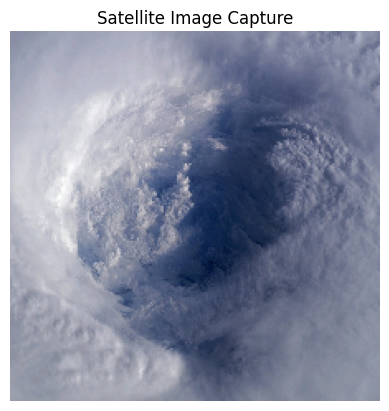

SavedModel Prediksi: cloudy (25.8%)


In [30]:
###
## Inference menggunakan SavedModel
###

# Load SavedModel
savedmodel_path = "/content/drive/MyDrive/Submission/Deep Learning/Image Classification/saved_model"
loaded_savedmodel = tf.saved_model.load(savedmodel_path)

# Load dan preprocess gambar
original_img = Image.open(img_dir1)
print(f"Resolusi asli: {original_img.size[0]} x {original_img.size[1]} pixels")

img = image.load_img(img_dir1, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
plt.imshow(img)
plt.axis('off')
plt.title("Satellite Image Capture")
plt.show()

# Prediksi dengan SavedModel
infer = loaded_savedmodel.signatures["serving_default"]
prediction_savedmodel = infer(tf.constant(img_array))

# Ambil hasil prediksi
try:
    pred_output = prediction_savedmodel['dense_3']
except:
    try:
        pred_output = prediction_savedmodel['output_0']
    except:
        pred_output = list(prediction_savedmodel.values())[0]

pred_savedmodel = pred_output.numpy()
predicted_idx = np.argmax(pred_savedmodel)
confidence = pred_savedmodel[0][predicted_idx] * 100

print(f"SavedModel Prediksi: {class_labels[predicted_idx]} ({confidence:.1f}%)")

Resolusi asli: 1280 x 846 pixels


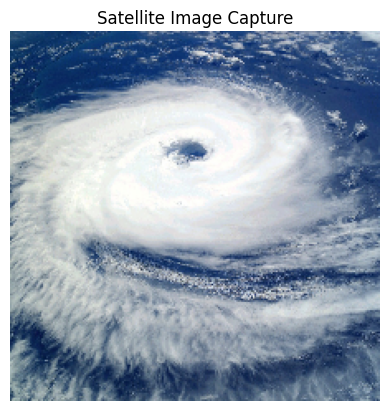

SavedModel Prediksi: cloudy (25.9%)


In [35]:
###
## Inference menggunakan SavedModel
###

# Load SavedModel
savedmodel_path = "/content/drive/MyDrive/Submission/Deep Learning/Image Classification/saved_model"
loaded_savedmodel = tf.saved_model.load(savedmodel_path)

# Load dan preprocess gambar
original_img = Image.open(img_dir2)
print(f"Resolusi asli: {original_img.size[0]} x {original_img.size[1]} pixels")

img = image.load_img(img_dir2, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
plt.imshow(img)
plt.axis('off')
plt.title("Satellite Image Capture")
plt.show()

# Prediksi dengan SavedModel
infer = loaded_savedmodel.signatures["serving_default"]
prediction_savedmodel = infer(tf.constant(img_array))

# Ambil hasil prediksi
try:
    pred_output = prediction_savedmodel['dense_3']
except:
    try:
        pred_output = prediction_savedmodel['output_0']
    except:
        pred_output = list(prediction_savedmodel.values())[0]

pred_savedmodel = pred_output.numpy()
predicted_idx = np.argmax(pred_savedmodel)
confidence = pred_savedmodel[0][predicted_idx] * 100

print(f"SavedModel Prediksi: {class_labels[predicted_idx]} ({confidence:.1f}%)")

Resolusi asli: 1280 x 853 pixels


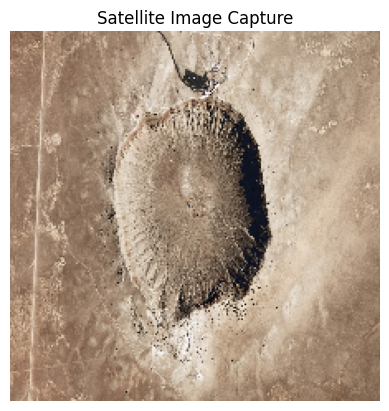

SavedModel Prediksi: desert (25.7%)


In [37]:
###
## Inference menggunakan SavedModel
###

# Load SavedModel
savedmodel_path = "/content/drive/MyDrive/Submission/Deep Learning/Image Classification/saved_model"
loaded_savedmodel = tf.saved_model.load(savedmodel_path)

# Load dan preprocess gambar
original_img = Image.open(img_dir3)
print(f"Resolusi asli: {original_img.size[0]} x {original_img.size[1]} pixels")

img = image.load_img(img_dir3, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
plt.imshow(img)
plt.axis('off')
plt.title("Satellite Image Capture")
plt.show()

# Prediksi dengan SavedModel
infer = loaded_savedmodel.signatures["serving_default"]
prediction_savedmodel = infer(tf.constant(img_array))

# Ambil hasil prediksi
try:
    pred_output = prediction_savedmodel['dense_3']
except:
    try:
        pred_output = prediction_savedmodel['output_0']
    except:
        pred_output = list(prediction_savedmodel.values())[0]

pred_savedmodel = pred_output.numpy()
predicted_idx = np.argmax(pred_savedmodel)
confidence = pred_savedmodel[0][predicted_idx] * 100

print(f"SavedModel Prediksi: {class_labels[predicted_idx]} ({confidence:.1f}%)")